<a href="https://colab.research.google.com/github/jakeramaer/Foram-Classifier-2020/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Planctonic Foraminifera Classifier

This classifier distinguises between 35 individual species of planktonic foraminifera (Species sample sizes can be viewed at http://endlessforams.org/).



In [ ]:
import keras
from keras import backend as K
from keras import layers, models, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

from google.colab import drive

import os, sys, glob, pickle, tempfile, shutil, random, zipfile, math

#Entering the parameters of the model.

Individual species names are named below:

>'beellaDigitata', 'candeinaNitida', 'globigerinaBulloides', 'globigerinaFalconensis', 'globigerinellaAdamsi',
           'globigerinellaCalida', 'globigerinellaSiphonifera', 'globigerinitaGlutinata', 'globigerinitaUvula',
           'globigerinoidesConglobatus', 'globigerinoidesElongatus', 'globigerinoidesRuber', 'globigerinoidesSacculifer',
           'globoquadrinaConglomerata', 'globorotaliaCrassaformis', 'globorotaliaHirsuta', 'globorotaliaInflata',
           'globorotaliaMenardii', 'globorotaliaScitula', 'globorotaliaTruncatulinoides', 'globorotaliaTumida',
           'globorotaliaUngulata', 'globorotaloidesHexagonus', 'globoturborotalitaRubescens', 'globoturborotalitaTenella',
           'hastigerinaPelagica', 'neogloboquadrinaDutertrei', 'neogloboquadrinaIncompta', 'neogloboquadrinaPachyderma',
           'orbulinaUniversa', 'pulleniatinaObliquiloculata', 'sphaeroidinellaDehiscens', 'tenuitellaIota',
           'turborotalitaHumilis', 'turborotalitaQuinqueloba'

Suggested train, test, validation split is [80, 20].
          
Available CNN's are -
> 'vanilla', 'vgg16', 'vgg16_att'.

Available loss functions are - 
> 'binary_crossentropy','categorical_crossentropy', 'focal_loss'



In [ ]:
species = ['beellaDigitata', 'candeinaNitida', 'globigerinaBulloides', 'globigerinaFalconensis', 'globigerinellaAdamsi', 'globigerinellaCalida', 'globigerinellaSiphonifera', 'globigerinitaGlutinata', 'globigerinitaUvula', 'globigerinoidesConglobatus', 'globigerinoidesElongatus', 'globigerinoidesRuber', 'globigerinoidesSacculifer', 'globoquadrinaConglomerata', 'globorotaliaCrassaformis', 'globorotaliaHirsuta', 'globorotaliaInflata', 'globorotaliaMenardii', 'globorotaliaScitula', 'globorotaliaTruncatulinoides', 'globorotaliaTumida', 'globorotaliaUngulata', 'globorotaloidesHexagonus', 'globoturborotalitaRubescens', 'globoturborotalitaTenella', 'hastigerinaPelagica', 'neogloboquadrinaDutertrei', 'neogloboquadrinaIncompta', 'neogloboquadrinaPachyderma', 'orbulinaUniversa', 'pulleniatinaObliquiloculata', 'sphaeroidinellaDehiscens', 'tenuitellaIota', 'turborotalitaHumilis', 'turborotalitaQuinqueloba']
split = [80, 20]

analysis_id = 1

augment = True
load_weights = False
show_model_summary = True
image_size = 224
batch_size = 100
epochs = 50
lrate = 0.0001
drop = 0.5
lmbda = 0.01
layer_freeze = 0

cnn = 'vgg16_att'
model_loss = 'categorical_crossentropy'
model_optimiser = optimizers.Adam(lr=lrate)

# A sample of preloadable weights
weights_path_att = '/content/gdrive/My Drive/weights/saved/CBAM_epochs:039-val_acc:0.904.hdf5'
reference_weights = '/content/gdrive/My Drive/weights/saved/foram-classifier-model-weights.h5'

# A location to save learned weights
savepath = '/content/gdrive/My Drive/weights/CBAM_epochs:{epoch:03d}-val_acc:{val_acc:.3f}.h5'

#Accessing the Google Drive zip file.

The dataset should be organised as dataset/'individual_species'/cropped/, with the  folder containing samples of 1 species.

In [ ]:
drive.mount('/content/gdrive')
googledrive_zip = '/content/gdrive/My Drive/shuffled_dataset.zip'
zip_ref = zipfile.ZipFile(googledrive_zip, 'r')
print("Extracting zipped dataset from Google Drive...")
zip_ref.extractall('/tmp')
print("done.")
zip_ref.close()
base_dir = '/tmp/shuffled_dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Extracting zipped dataset from Google Drive...
done.


#Foram Model definitions

In [ ]:
def vanilla_cnn(model, image_size):
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3), name='cov1'))
    model.add(layers.MaxPooling2D((2, 2), name='maxp1'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', name='cov2'))
    model.add(layers.MaxPooling2D((2, 2), name='maxp2'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', name='cov3'))
    model.add(layers.MaxPooling2D((2, 2), name='maxp3'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', name='cov4'))
    model.add(layers.MaxPooling2D((2, 2), name='maxp4'))

In [ ]:
def vgg16_att(include_top=True,
                  weights=None,
                  input_shape=None,
                  attention_module=None):

    preloaded = keras.applications.vgg16.VGG16(include_top=False, 
                                         weights='imagenet', 
                                         input_shape = (image_size, image_size, 3))

    x = preloaded.layers[3].output
    # if attention_module is not None:
    #         x = attach_attention_module(x, attention_module)

    x = preloaded.layers[4](x)
    x = preloaded.layers[5](x)
    # if attention_module is not None:
    #         x = attach_attention_module(x, attention_module)
    x = preloaded.layers[6](x)

    x = preloaded.layers[7](x)
    x = preloaded.layers[8](x)
    x = preloaded.layers[9](x)
    # if attention_module is not None:
    #     x = attach_attention_module(x, attention_module)
    x = preloaded.layers[10](x)

    x = preloaded.layers[11](x)
    x = preloaded.layers[12](x)  
    x = preloaded.layers[13](x)
    # if attention_module is not None:
    #     x = attach_attention_module(x, attention_module)
    x = preloaded.layers[14](x)

    x = preloaded.layers[15](x)
    x = preloaded.layers[16](x)
    x = preloaded.layers[17](x)  
    

    if attention_module is not None:
        x = attach_attention_module(x, attention_module)
    x = preloaded.layers[18](x)

    # Create model.
    model = Model(preloaded.input, x, name='vgg16')

    return model

#Helper Functions


In [ ]:
# Graph plotting function for model evaluation
def plot_graphs(history, acc, val_acc, loss, val_loss):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
# Creates tain and validation directories for the chosen species.
def create_dataset(species, src, dest, split):
    train = os.path.join(os.path.join(dest, 'train'), species)
    validation = os.path.join(os.path.join(dest, 'validation'), species)
    os.mkdir(train)
    os.mkdir(validation)

    image_list = os.listdir(src)
    # Dataset is now already shuffled, no need to shuffle every time, gives more accurate 
    # random.shuffle(image_list)
    image_list_len = len(image_list)

    cut_1 = round(image_list_len*split[0]//100)
    cut_2 = round(cut_1 + image_list_len*split[1]//100)

    for i in range(0, cut_1):
        shutil.copy(os.path.join(src, image_list[i]), train)
    for i in range(cut_1, cut_2):
        shutil.copy(os.path.join(src, image_list[i]), validation)

    return cut_1

#Focal Loss function
source - https://github.com/umbertogriffo/focal-loss-keras 

In [ ]:
def categorical_focal_loss(alpha, gamma=2):
    
    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed


#CBAM Module
source - https://github.com/kobiso/CBAM-keras

In [ ]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.hape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		

# Training Functions

In [ ]:
tempdirectory = '/content/'
# Creating temporary train and validation directories for model training
train = os.path.join(tempdirectory, 'train')
validation = os.path.join(tempdirectory, 'validation')
os.mkdir(train)
os.mkdir(validation)
sample_number = 0

# Copying samples to temp directories
print('Starting species copy...')
for n, i in enumerate(species):
  species_dir = os.path.join(base_dir, i)
  sample_number += create_dataset(i, species_dir, tempdirectory, split)
print('done.')
steps_per_epoch = math.floor(sample_number / batch_size)

Starting species copy...
done.


58892288/58889256 [==============================] - 2s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________

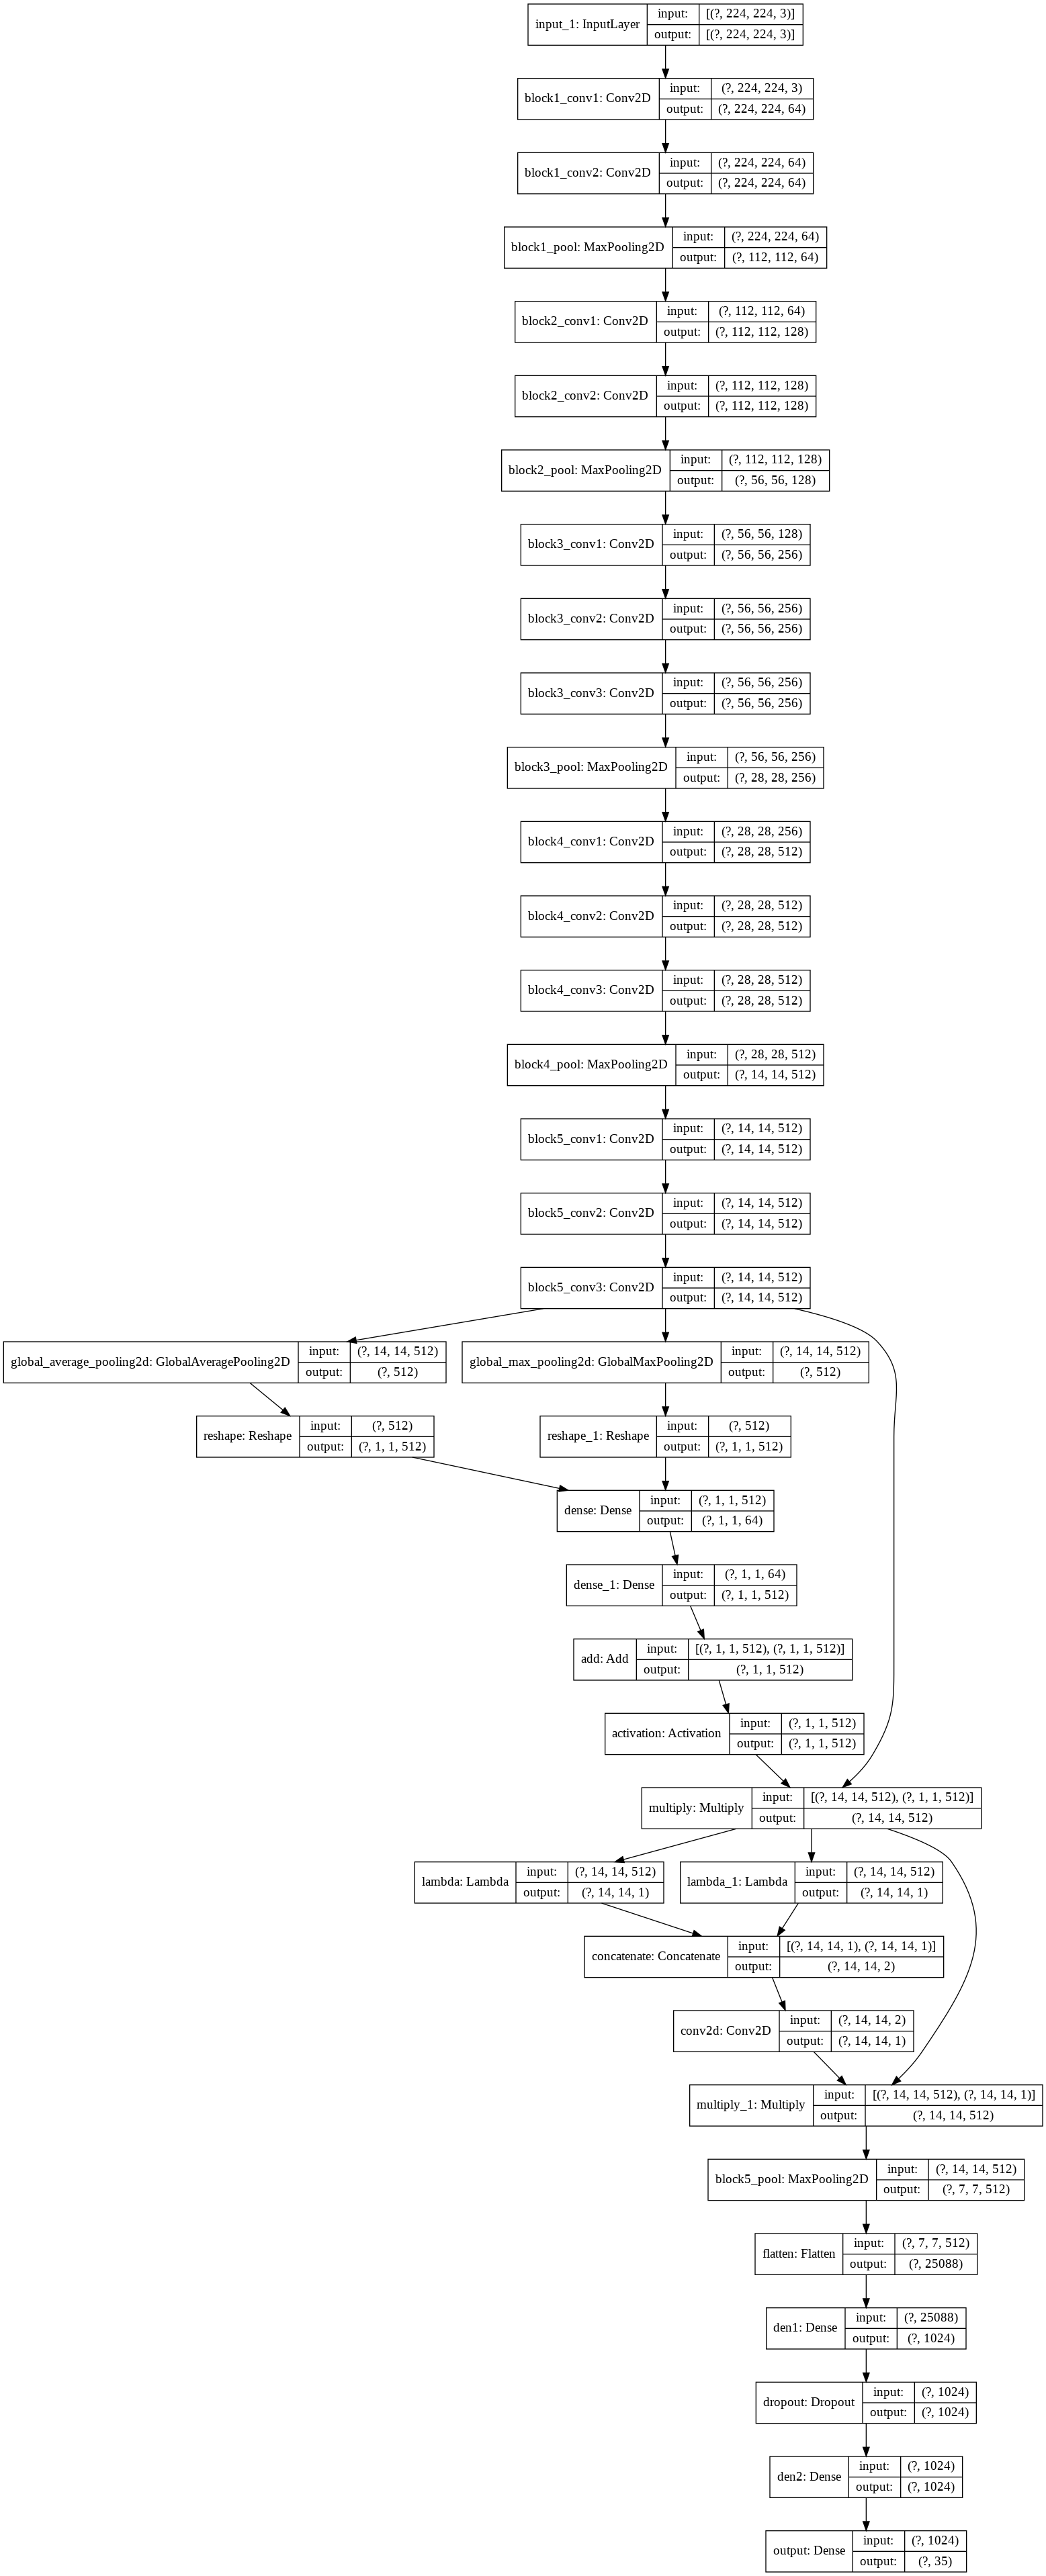

In [ ]:
# Selecting Classifier
if cnn == 'vanilla':
  model = models.Sequential()
  vanilla_cnn(model, image_size)
  layer_freeze = 0

elif cnn == 'vgg16':
  model = keras.applications.vgg16.VGG16(include_top=False, 
                                         weights='imagenet', 
                                         input_shape = (image_size, image_size, 3))

if cnn == 'vgg16_att':
  model = vgg16_att(include_top=False,
                  weights='imagenet',
                  input_shape=(image_size, image_size, 3),
                  attention_module='cbam_block')
 
# Freezing layers
for layer in model.layers[:layer_freeze]:
  layer.trainable=False

# Adding custom top to chosen CNN
x = model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu", name='den1')(x)
if drop:
  x = layers.Dropout(drop)(x)
x = layers.Dense(1024, activation="relu", name='den2')(x)
predictions = layers.Dense(len(species), activation="softmax", name='output')(x)

model_final = Model(inputs = model.input, outputs = predictions)

# Loading past weights
if(load_weights):
  if(cnn == 'vgg16'):
    model_final = keras.models.load_model(weights_path)
  elif(cnn == 'vgg16_att'):
    model_final = keras.models.load_model(weights_path_att)

# Focal loss
alpha = 0.5
gamma=2
if(model_loss == 'focal_loss'):
  model_loss = [categorical_focal_loss(alpha=[np.full((35), alpha)], gamma)]


# Printing model summary
if show_model_summary == True:
  print('Model Summary')
  model_final.summary()
  print('Trainable layers list')
  for layer in model_final.layers:
    print(layer, layer.trainable)
  print('Model Architecture plot')
  plot_model(model_final, to_file='model.png', show_shapes=True,show_layer_names=True)

In [ ]:
# Model compilation and training
model_final.compile(
              loss=model_loss,
              optimizer=model_optimiser,
              metrics=['acc'])

# Data augmentation
if(augment == True):
  print('Performing on the fly data augmentation')
  train_datagen = ImageDataGenerator(rescale=1./255,      
                                      rotation_range = 360,
                                      brightness_range = [0.5, 1.5],
                                      zoom_range = 0.2,
                                      fill_mode = 'nearest')
else:
  train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(train,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Saving model for top validation acc
filepath=savepath
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='auto')

# Early stopping monitor (will stop run if validation accuracy doesn't improve for 10 epochs)
early = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')

callbacks = [checkpoint]
history = model_final.fit(train_generator,
                          epochs=epochs,
                          #steps_per_epoch=steps_per_epoch,
                          validation_data=validation_generator,
                          callbacks = callbacks)

model_final.save('categorical_tq_gs.h5')

# Graph plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_graphs(history, acc, val_acc, loss, val_loss)

# Save histories
with open('analysis_{:s}_history.pkl'.format(analysis_id), 'wb') as f:
  pickle.dump(history.history,f)

# Model Evaluation Techniques

These methods are included to provide both qualitative and quantitative insight into how the model is performing. 

source - https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [ ]:
# Used for Visualising filters and feature maps
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
numpy.set_printoptions(threshold=sys.maxsize)

# test image path
img_path = '/content/gdrive/My Drive/Test_Images/globigerinoidesRuber(3185).jpg'    # Ruber

# load the model
# redefine model to output right after the first hidden layer
ixs = [2, 5, 8, 12, 16, 18]
outputs = [model_final.layers[i].output for i in ixs]
model_f = Model(inputs=model_final.inputs, outputs=outputs)

# load the image with the required shape
img = load_img(img_path, target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model_f.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()
 
# Printing filters
filters, biases = model_final.layers[5].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()
 

# Grad Cam implementation

adapted from - https://keras.io/examples/vision/grad_cam/

In [ ]:
from keras.applications.vgg16 import (VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import functools

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def create_dataset_grad(species, src, dest):
    sample = os.path.join(os.path.join(dest, 'samples'), species)
    os.mkdir(sample)
    image_list = os.listdir(src)
    shutil.copy(os.path.join(src, image_list[0]), sample)


img_size = (244, 244)

last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    'flatten', 
    'den1', 
    'dropout', 
    'den2', 
    'output'
]

# Model loading
model_final_grad = keras.models.load_model(weights_path_att)

# Creating dataset
tempdirectory = '/content/'
samples = os.path.join(tempdirectory, 'samples')
os.mkdir(samples)
for n, i in enumerate(species):
  species_dir = os.path.join(base_dir, i)
  create_dataset_grad(i, species_dir, tempdirectory)

samples_datagen = ImageDataGenerator(rescale=1./255)
samples_generator = samples_datagen.flow_from_directory(samples,
                                                    target_size=(image_size, image_size),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    shuffle=False)

preds = model_final_grad.predict(samples_generator)

# Creating list of image paths
img_paths=[]
for n, i in enumerate(species):
  species_dir = os.path.join(base_dir, i)
  image_list = os.listdir(species_dir)
  img_paths.append(os.path.join(species_dir, image_list[0]))

# Generate a Grad-Cam heat-map for each of the samples
for i in range(0,35):
  img_array, truth = samples_generator.next()
  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(
      img_array, model_final_grad, last_conv_layer_name, classifier_layer_names
  )

  # We load the original image
  img = keras.preprocessing.image.load_img(img_paths[i])
  img = keras.preprocessing.image.img_to_array(img)

  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "elephant_cam.jpg"
  superimposed_img.save(save_path)

  species_prediction = np.argmax(preds[i])
  print('Classification number - ', i)
  print('Predicted Species = ', species[species_prediction])
  print('Ground Truth = ', species[i], '\n')

  # Display heatmap
  plt.matshow(heatmap)
  plt.show()

  # Display Grad CAM
  display(Image(save_path))

# Removing temporary samples directory
shutil.rmtree(samples)

In [ ]:
# Generate classification report
from sklearn import svm, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

test_datagen_f1 = ImageDataGenerator(rescale=1./255)
validation_generator_f1 = test_datagen_f1.flow_from_directory(validation,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

weights_path_img = '/content/gdrive/My Drive/weights/FL_DATAAUG_epochs:038-val_acc:0.893.h5'
  
model_final_f1 = keras.models.load_model(weights_path_img, custom_objects={'categorical_focal_loss_fixed': categorical_focal_loss})
model_final_f1.compile(
              loss=model_loss,
              optimizer=model_optimiser,
              metrics=['acc'])
y_pred = model_final_f1.predict(validation_generator_f1)
y_pred = np.argmax(y_pred, axis=1)

a = []
for i in range(0, 5527):
  # print(validation_generator_f1.classes[i], ' - ' , y_pred[i])
  if( y_pred[i] == 1):
    a.append('1')
print(len(a))

# print('Confusion Matrix')
# print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator_f1.classes, y_pred))

In [ ]:
# Used to remove temporary datasets imported from google drive
shutil.rmtree(train)
shutil.rmtree(validation)